## Import Packages

In [1]:
import pandas as pd
import numpy as np
#from google.colab import drive
import numpy

%pip install tf-explain tensorflow==2.2.0
from tensorflow.keras.preprocessing import image
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity
from tf_explain.core.grad_cam import GradCAM
import matplotlib.pyplot as plt
%matplotlib inline
import cProfile
from tensorflow import keras 
import tensorflow
from tensorflow.keras.preprocessing import image

from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D,GlobalAveragePooling2D, Dense , BatchNormalization, Dropout, Conv2D, MaxPooling2D,Activation,Flatten
from tensorflow.keras import backend
import random

from tf_explain.utils.display import image_to_uint_255
import cv2

from tensorflow.keras.datasets import fashion_mnist
import tensorflow_datasets as tfds
import os
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from matplotlib.patches import Rectangle
from scipy.io import loadmat
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


## Model Helper Functions

In [46]:
def custom_get_gradients_and_filters(
    model, images, layer_name, class_index, use_guided_grads
):
    """
    Generate guided gradients and convolutional outputs with an inference.
    Args:
        model (tf.keras.Model): tf.keras model to inspect
        images (numpy.ndarray): 4D-Tensor with shape (batch_size, H, W, 3)
        layer_name (str): Targeted layer for GradCAM
        class_index (int): Index of targeted class
        use_guided_grads (boolean): Whether to use guided grads or raw gradients
    Returns:
        Tuple[tf.Tensor, tf.Tensor]: (Target layer outputs, Guided gradients)
    """
    grad_model = tensorflow.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    with tensorflow.GradientTape() as tape:
        inputs = tensorflow.cast(images, tensorflow.float32)
        conv_outputs, predictions = grad_model(inputs)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)

    if use_guided_grads:
        grads = (
            tensorflow.cast(conv_outputs > 0, "float32")
            * tensorflow.cast(grads > 0, "float32")
            * grads
        )

    return conv_outputs, grads

In [47]:
def apply_heatmap_occlusion(
    heatmap, original_image, THRESHOLD=0.85
):
    """
    Apply a heatmap (as an np.ndarray) on top of an original image.
    Args:
        heatmap (numpy.ndarray): Array corresponding to the heatmap
        original_image (numpy.ndarray): Image on which we apply occlusion
    Returns:
        np.ndarray: Original image with heatmap applied
    """
    heatmap = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))

    heatmap = (heatmap - np.min(heatmap)) / (heatmap.max() - heatmap.min())

    super_threshold_indices = (heatmap>THRESHOLD)

    output = original_image
    output[super_threshold_indices] = 0.0
    return output

In [48]:
def batch_gradCAM_augmentationn(images,y_matrix,model, layer_name = 'mixed10'):
  contador = 0
  explainer = GradCAM()
  images_mod = images.numpy()

  for i in range(0,tensorflow.shape(images_mod)[0]):

    
    class_index = tensorflow.argmax(y_matrix[i])

    outputs, grads = custom_get_gradients_and_filters(
        model, np.expand_dims(images_mod[i], axis=0), layer_name, class_index, True
    )

    grid = explainer.explain((np.expand_dims(images_mod[i], axis=0),None), model, layer_name = layer_name, class_index= class_index)
    #explainer.save(grid, "./grad_cam_batch/", "heatmap_batch"+str(contador)+".jpg")
    cams = explainer.generate_ponderated_output(outputs, grads)
    heatmap = apply_heatmap_occlusion(cams[0].numpy(), images_mod[i])
    #explainer.save(image_to_uint_255(images_mod[i]), "./grad_cam_batch/", "original_batch"+str(contador)+".jpg")
    #explainer.save(image_to_uint_255(heatmap), "./grad_cam_batch/", "grad_cam_batch"+str(contador)+".jpg")
    #explainer.save(image_to_uint_255(images.numpy()[i]), "./grad_cam_batch/", "tensor"+str(contador)+".jpg")
    contador = contador+1
    #salvamos la imagen modificada
    images_mod[i]=heatmap
  images = tensorflow.convert_to_tensor(images_mod)
  return images,y_matrix

In [49]:
import tensorflow
import numpy
class CustomModel(tensorflow.keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data
        n_random=random.random()
        P_Occlusion = 0.25
        #tensorflow.print("augmentation "+ str(n_random))

        if(n_random<=P_Occlusion):
          x,y = batch_gradCAM_augmentationn(x,y,self)

        with tensorflow.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

In [50]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Begin DataLoading Aircraft

In [8]:
def load_aircraft_labels(filename):
  df = pd.DataFrame(columns = ['Image', 'Variant'])
  with open(filename, 'r') as f:
    l = f.readline()
    i = 0
    while l:
      g = l.strip().split(' ')
      df = df.append(pd.DataFrame({'Image':'/content/drive/MyDrive/fgvc-aircraft-2013b/data/images/'+str(g[0]) + '.jpg',
                                   'Variant': ''.join(g[1:])}, index=[i]))
      i+=1
      l = f.readline()
  return df

In [9]:
df_train = load_aircraft_labels('/content/drive/MyDrive/fgvc-aircraft-2013b/data/images_variant_trainval.txt')
df_valid = load_aircraft_labels('/content/drive/MyDrive/fgvc-aircraft-2013b/data/images_variant_val.txt')
df_test = load_aircraft_labels('/content/drive/MyDrive/fgvc-aircraft-2013b/data/images_variant_test.txt')

In [10]:
# Only use 50 classes
labels_reduced = df_train.Variant.unique()[:50]
df_train = df_train[df_train['Variant'].isin(labels_reduced)]
df_train.reset_index(inplace=True)
df_test = df_test[df_test['Variant'].isin(labels_reduced)]
df_test.reset_index(inplace = True)

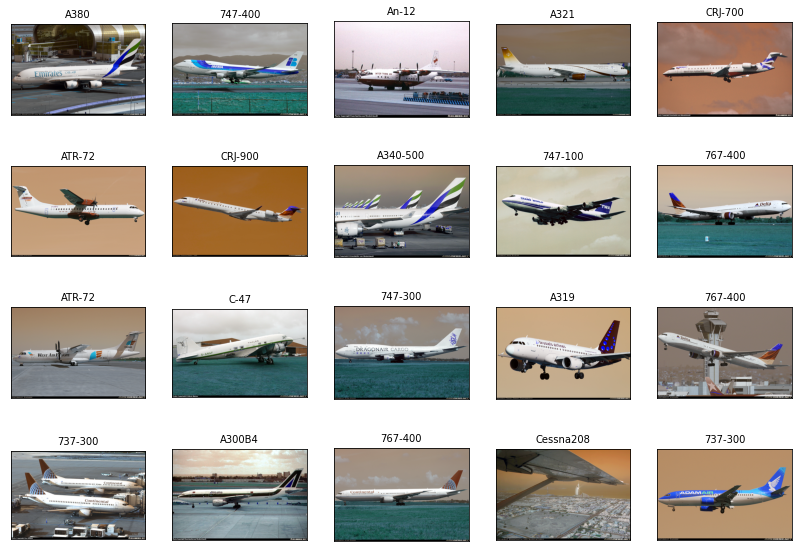

In [11]:
plt.figure(figsize = (14,10))
for i in range(20):
    random1 = np.random.randint(1,len(df_train))
    plt.subplot(4,5,i+1)
    plt.imshow(cv2.imread(str(df_train.loc[random1,"Image"])))
    plt.title(df_train.loc[random1, "Variant"], size = 10, color = "black") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

## Train datagen

In [20]:
target_size=(224,224)
batch_size=64

In [63]:
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input, horizontal_flip=True, zoom_range=0.1)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)
train_gen = train_datagen.flow_from_dataframe(df_train, x_col='Image', y_col='Variant', target_size=target_size, batch_size=batch_size, color_mode='rgb', class_mode='categorical')
test_gen = test_datagen.flow_from_dataframe(df_test,  x_col='Image', y_col='Variant', target_size=target_size, batch_size=batch_size, color_mode='rgb', class_mode='categorical')

Found 3334 validated image filenames belonging to 50 classes.
Found 1666 validated image filenames belonging to 50 classes.


## Begin Model

In [55]:
# Instantiate model
from tensorflow.keras.applications import InceptionV3
img_height,img_width = 224,224
inceptionV3 = InceptionV3(weights='imagenet',include_top=False,input_shape=(img_height,img_width,3))
x = BatchNormalization()(inceptionV3.output)
x = Activation('relu')(x)
#x = AveragePooling2D(pool_size=3)(x)
x = Flatten()(x)
n_classes = 50
output = Dense(n_classes, activation='softmax', name="prediction_layer")(x)
model = CustomModel(inputs=[inceptionV3.input], outputs = output)

In [56]:
#tf.executing_eagerly()
import numpy

earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10,  verbose=1, mode='min')
callbacks_list = [earlystop]
# Compile model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0001),  metrics=['acc',f1_m,precision_m, recall_m])

# Fit on small number of epochs
model.fit(train_gen, batch_size=64, epochs=50 , validation_data=test_gen, callbacks=callbacks_list)

# @ JOSH ALLEN RUN THIS IN YOUR SUPERCOMP not the above
# model.fit(train_gen, batch_size=64, epochs=250,)# validation_data=(X_test, y_test))
model.save('/content/drive/MyDrive/aircraft_base_model_50epochs_50class_run2.h5')

Epoch 1/50
27/27 [==============================] - 54s 2s/step - loss: 4.3802 - acc: 0.0618 - f1_m: 0.0110 - precision_m: 0.1617 - recall_m: 0.0058 - val_loss: 4.4227 - val_acc: 0.0438 - val_f1_m: 0.0118 - val_precision_m: 0.0977 - val_recall_m: 0.0064
Epoch 2/50
27/27 [==============================] - 53s 2s/step - loss: 0.6323 - acc: 0.9010 - f1_m: 0.7811 - precision_m: 0.9493 - recall_m: 0.6678 - val_loss: 3.3646 - val_acc: 0.1735 - val_f1_m: 0.0960 - val_precision_m: 0.5733 - val_recall_m: 0.0573
Epoch 3/50
27/27 [==============================] - 53s 2s/step - loss: 0.0953 - acc: 0.9928 - f1_m: 0.9536 - precision_m: 0.9594 - recall_m: 0.9479 - val_loss: 2.4436 - val_acc: 0.3493 - val_f1_m: 0.2695 - val_precision_m: 0.5869 - val_recall_m: 0.1852
Epoch 4/50
27/27 [==============================] - 53s 2s/step - loss: 0.1337 - acc: 0.9856 - f1_m: 0.9442 - precision_m: 0.9568 - recall_m: 0.9323 - val_loss: 1.8454 - val_acc: 0.5204 - val_f1_m: 0.4105 - val_precision_m: 0.8490 - val_r

In [57]:
res = pd.DataFrame(model.history.history)
# res.to_csv('/content/drive/MyDrive/expt_results/aircraft_expt_50epochs_withcallbacks_lowerLR.csv')

## TL

In [67]:
# Instantiate model VGG (2nd pass ResNet50)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
img_height,img_width = 224,224
vgg16 = ResNet50(weights='imagenet',include_top=False,input_shape=(img_height,img_width,3))
x = BatchNormalization()(vgg16.output)
x = Activation('relu')(x)
#x = AveragePooling2D(pool_size=3)(x)
x = Flatten()(x)
n_classes = 50
output = Dense(n_classes, activation='softmax', name="prediction_layer")(x)
model = CustomModel(inputs=[vgg16.input], outputs = output)

In [71]:
#tf.executing_eagerly()
import numpy

earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=50,  verbose=1, mode='min')
callbacks_list = [earlystop]
# Compile model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0001),  metrics=['acc',f1_m,precision_m, recall_m])

# Fit on small number of epochs
model.fit(train_gen, batch_size=64, epochs=50 , validation_data=test_gen, callbacks=callbacks_list)

# @ JOSH ALLEN RUN THIS IN YOUR SUPERCOMP not the above
# model.fit(train_gen, batch_size=64, epochs=250,)# validation_data=(X_test, y_test))
model.save('/content/drive/MyDrive/aircraft_base_model_50epochs_50class_resnet50.h5')

Epoch 1/50
53/53 [==============================] - 111s 2s/step - loss: 7.6710 - acc: 0.0813 - f1_m: 0.0456 - precision_m: 0.1113 - recall_m: 0.0292 - val_loss: 4.0349 - val_acc: 0.0288 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/50
53/53 [==============================] - 109s 2s/step - loss: 5.7488 - acc: 0.0780 - f1_m: 0.0227 - precision_m: 0.0959 - recall_m: 0.0130 - val_loss: 3.9911 - val_acc: 0.0246 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/50
53/53 [==============================] - 109s 2s/step - loss: 4.8448 - acc: 0.0939 - f1_m: 0.0249 - precision_m: 0.1361 - recall_m: 0.0139 - val_loss: 3.9395 - val_acc: 0.0306 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/50
53/53 [==============================] - 109s 2s/step - loss: 4.3215 - acc: 0.1125 - f1_m: 0.0181 - precision_m: 0.1370 - recall_m: 0.0097 - val_loss: 3.8830 - val_acc: 0.0384 - val_f1_m: 

In [69]:
res = pd.DataFrame(model.history.history)
res.to_csv('/content/drive/MyDrive/expt_results/aircraft_expt_50epochs_withcallbacks_resnet50.csv')